## Loop Shift Normalized Data Analysis Notebook

### Read Me
    1. This notebook should be run from the top cell down.  Running in a different order will cause errors.
    2. All values that may need to be edited will appear in the cell immediately following this one.
    3. This cell normalizes the y data from [-1,1] and then searches for the two closest points surrounding y = 0 and then solves for x at y=0
    4. This notebook will fail for cases where data is too noisy (crosses the y=0 line more than 2 times)

In [1]:
# * represents wildcard characters, desired file name types should be typed explicitly surrounded by *, ie: *desired_field*
# for positive current values make sure to preface with an underscore to avoid also getting negative in-plane fields, ie: _400
directory = r'C:\Users\Neuromancer\Desktop\AHE_annealed\Pt2\*_200.0Oe*'

# Device characteristics
w = 10e-6 # device width (meters)
d = 4e-9 # thickness of spin Hall material (meters) 
t = 1.4e-9 # thickness of magnetic layer - dead layer (meters)
M = 1500 * 1000 # saturization magnetization (A/m)
rho_FM = 40 # resistivity of magnetic layer (uOhm-cm)
rho_HM = 300 # resistivity of spin Hall material (uOhm-cm)

No errors found.
I-Dc (mA)    Hall-loop files in current folder
-1.9         C:\Users\Neuromancer\Desktop\AHE_annealed\Pt2\2AHE_DC_4650.47Ohm_200.0Oe_-1.9mA_2018-10-04-144447
-1.5         C:\Users\Neuromancer\Desktop\AHE_annealed\Pt2\2AHE_DC_4678.39Ohm_200.0Oe_-1.5mA_2018-10-04-144412
-1.1         C:\Users\Neuromancer\Desktop\AHE_annealed\Pt2\2AHE_DC_4473.69Ohm_200.0Oe_-1.1mA_2018-10-04-144336
-0.7         C:\Users\Neuromancer\Desktop\AHE_annealed\Pt2\2AHE_DC_4783.15Ohm_200.0Oe_-0.7mA_2018-10-04-144300
-0.3         C:\Users\Neuromancer\Desktop\AHE_annealed\Pt2\2AHE_DC_4652.8Ohm_200.0Oe_-0.3mA_2018-10-04-144224
0.1         C:\Users\Neuromancer\Desktop\AHE_annealed\Pt2\2AHE_DC_4770.02Ohm_200.0Oe_0.1mA_2018-10-04-144149
0.5         C:\Users\Neuromancer\Desktop\AHE_annealed\Pt2\2AHE_DC_4775.42Ohm_200.0Oe_0.5mA_2018-10-04-144113
0.9         C:\Users\Neuromancer\Desktop\AHE_annealed\Pt2\2AHE_DC_4490.08Ohm_200.0Oe_0.9mA_2018-10-04-144038
1.3         C:\Users\Neuromancer\Desktop\AHE_annealed\P

<IPython.core.display.Javascript object>


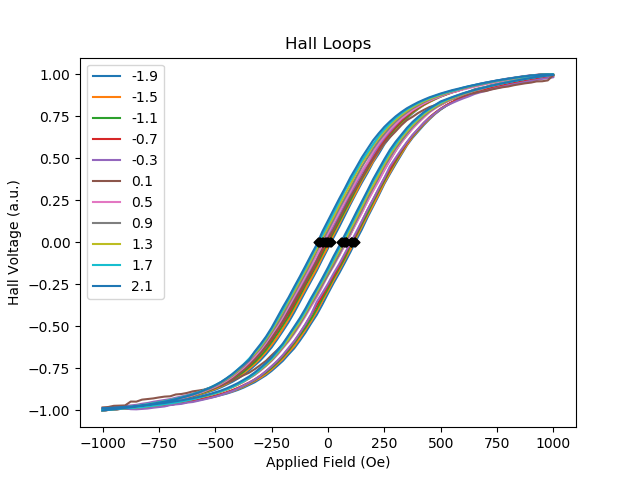

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np 
import glob as glob


FileList = []


# takes filepath and returns float current(mA) value
def getCurrent(file):
    for x in file.split('_'):
        if x.endswith('mA'):
            return (float(x[0:(len(x) - 2)]))
        
# takes file and unpacks data from it so it can be graphed in matplotlib, returns numpy array
def unpack(file, array):
    f = np.loadtxt(file, delimiter=None, skiprows=5, usecols=(1,2))
    index = array.shape[1] #index of where to add t to array
    #loop to find first empty column in the array
    for n in range(0, array.shape[1]):
        if (array[:, n]==0).all() and (index > n):
            index = n
    
    # if index == 0, then add both x and y data, otherwise add y data only
    if (index == 0):
        array[0:array.shape[0],index:2] += f
        #print('first addition')
    else:
        array[0:array.shape[0],index] += f[0:array.shape[0], 1]
        #print('more data added at', index)
    
    return array
                
# finds the length of file data and number of files, returns as tuple
def dataSize():
    q = np.loadtxt(FileList[0][0], delimiter=None, skiprows=5, usecols=(0))
    return ((q.shape[0], len(FileList)+1))

# normalizes an array passed to it and returns the normalized version (from -1 to 1)
def normalize(array):
    normed = (((array - array.min(0)) / array.ptp(0)) - 0.5) * 2
    return normed

# searches through directory and creates list of tuples (filepath, float(current))
for j in glob.glob(directory):
    FileList.append((j, getCurrent(j)))
    
# sort tuple list by current
FileList.sort(key=lambda tup: tup[1])

#initialize Dataset to array of all 0's
DataSet = np.zeros(dataSize())

#creates tuples of numpy array and corresponding current value
for x in FileList:
    DataSet = unpack(x[0], DataSet)
    
#checks to make sure data set has transfered properly    
if (DataSet[:,:] == 0).any():
    print('zero error!')
else:
    print('No errors found.')

#normalize all hall voltage values
DataSet[:, 1:] = normalize(DataSet[:, 1:])


# Lists all currents and files pulled
print('I-Dc (mA)    Hall-loop files in current folder')
for x in FileList:
    print(x[1], '       ', x[0])

# half of data, 1 peak per half
h = int(DataSet.shape[0]/2) # will round down if odd number of points
adj = 0 # adjustment factor for indexing
if DataSet.shape[0] % 2 == 0:
    adj = 0
else: 
    adj = 1

    
clow = np.zeros(DataSet.shape[1]-1) # -Hz value closest to y = zero
chigh = np.zeros(DataSet.shape[1]-1) # +Hz value closest to y = zero
norm_v = np.zeros(DataSet.shape[1]-1) # all zeros for easy graphing
ind_low = np.zeros(DataSet.shape[1]-1) # low index of lower bound
ind_l = np.zeros(DataSet.shape[1]-1) # low index of higher bound
ind_high = np.zeros(DataSet.shape[1]-1) # high index  of lower bound
ind_h = np.zeros(DataSet.shape[1]-1) # high index of higher bound

#function that looks for sign change in data points and pulls index from those points
def find_nearest(array):
    asign = np.sign(array)
    if asign.any() == 0.0:
        idx = np.where(asign == 0.0)
        print('zero index at: ', inx[0])
        return idx[0], idx[0]
    else:
        signchange = (np.roll(asign, 1) - asign)
        signchange[0] = 0 # account for the fact that roll one compares sign change of 1st and last element of asign
        idx = np.where(signchange != 0)
        return idx[0]-1, idx[0]


# finds min/max indexes of the arrays (n and m), then appends index to clow/chigh
for x in range(1, DataSet.shape[1]):
    n = DataSet[:h, x]
    m = DataSet[h + 1:, x]
    ind_low[x-1], ind_l[x-1] = find_nearest(n) # finds -Hz index values closest to y = 0
    ind_high[x-1], ind_h[x-1] = find_nearest(m) # finds +Hz index values closest to y = 0

ind_high += h+adj # adjust index for array split in half
ind_h += h+adj # adjust index for array split in half


# find y intercept of each set
for j in range(ind_high.shape[0]):
    # get slope and intercept from low and high bounds
    if ind_low[j] == ind_l[j]: # only occurs when exactly 0
        clow[j] = DataSet[int(ind_low[j]), 0]
    else:
        low_x = DataSet[int(ind_low[j]):int(ind_l[j])+1, 0]
        low_y = DataSet[int(ind_low[j]):int(ind_l[j])+1, j+1]
        m_l, b_l = np.polyfit(low_x, low_y, 1)
        clow[j] = -b_l / m_l # - Hc value at y = 0
    if ind_high[j] == ind_h[j]:
        chigh[j] = DataSet[int(ind_high[j]), 0]
    else:
        high_x = DataSet[int(ind_high[j]):int(ind_h[j])+1, 0]
        high_y = DataSet[int(ind_high[j]):int(ind_h[j])+1, j+1]
        m_h, b_h = np.polyfit(high_x, high_y, 1)
        chigh[j] = -b_h / m_h # + Hc value at y = 0

    
# plot loops    
plt.figure()
for i in range(1, DataSet.shape[1]):
    plt.plot(DataSet[:,0], DataSet[:,i], label=str(FileList[i-1][1]), zorder=0)

# plot Hc points found
plt.scatter(clow, norm_v, s=20, c='black', marker='D', zorder=1)
plt.scatter(chigh, norm_v, s=20, c='black', marker='D', zorder=1)

#matplotlib plot commands
plt.title('Hall Loops')
plt.xlabel('Applied Field (Oe)')
plt.ylabel('Hall Voltage (a.u.)')
plt.legend()
plt.show()

Currents (mA)  [-1.9 -1.5 -1.1 -0.7 -0.3  0.1  0.5  0.9  1.3  1.7  2.1]
Fitted Line - Slope:  -15.521374852751677 Intercept:  37.616714947004326
Field per Current Density in 10e11 * Oe/A*m^-2:  -0.0006208549941100673
Spin Hall Angle:  -0.2515218141059445


<IPython.core.display.Javascript object>


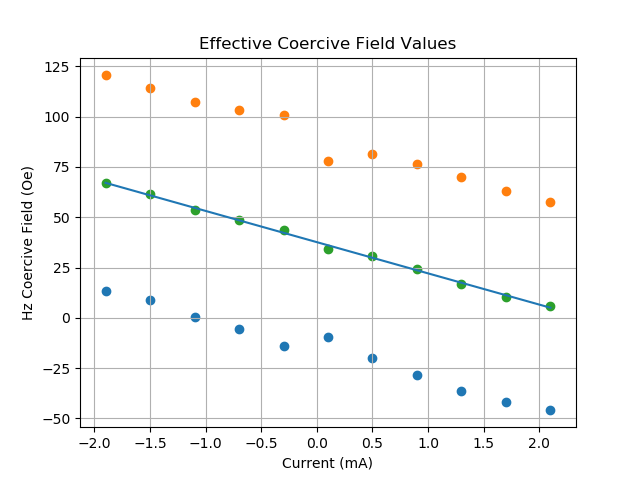

In [3]:
%matplotlib notebook
import math
from scipy import optimize
#Analyzer Code

cmean = np.zeros(DataSet.shape[1]-1) # mean array initialization
# find mean values
for x in range(chigh.shape[0]):
    cmean[x] = (chigh[x] + clow[x])/2
    

x_val = np.array([x[1] for x in FileList]) # array of current values
print('Currents (mA) ', x_val)

# scipy fitting using non-linear least squares fit 
def test_func(x, m, b): # test of linear fit, x variables, slope m, b intercept
    return (m * x) + b

params, params_covariance = optimize.curve_fit(test_func, x_val, cmean) # returns m and b values as params, covariance of fit
print('Fitted Line - Slope: ', params[0], 'Intercept: ', params[1])

# Current distribution ratio
ratio = (rho_FM * d) / (rho_FM * d + rho_HM * t)
print('Percentage current flowing in the spin-Hall material: ', ratio)

# Calculations of switching currents/SOT efficiency/etc.
HperJ = (params[0] * 10e11 * (1/1000) * (w * d)) # H/J in Oe/A*m^-2 * 10e11
print('Field per Current Density in 10e11 * Oe/A*m^-2: ', HperJ)

spin_hall_angle = (2 * M * t * w * d * params[0]) / (10 * 6.6e-16) * (2 / math.pi)
print('Spin Hall Angle: ', spin_hall_angle)

# matplotlib plot commands
plt.scatter(x_val, chigh)
plt.scatter(x_val, clow)
plt.scatter(x_val, cmean)
plt.plot(x_val, test_func(x_val, *params))
plt.grid(True)
plt.title('Effective Coercive Field Values')
plt.xlabel('Current (mA)')
plt.ylabel('Hz Coercive Field (Oe)')
plt.show()